In [1]:
from __init__ import PRP; import sys
sys.path.append(PRP)

import jax.numpy as jnp
import jax

In [2]:
PRP

'/Users/emeunier/Desktop/Projets/Veros-Autodiff/'

In [3]:
from scripts.grad_compare import *

Importing core modules
 Using computational backend jax on cpu
  Kernels are compiled during first iteration, be patient
 Runtime settings are now locked



In [28]:
acc = warmup_acc(2, override_settings={'enable_streamfunction' : False})
acc.state._diagnostics = {}
current_state = acc.state.copy()

Running model setup
 Running diagnostic "averages" every 5.0 days
 Writing output for diagnostic "averages" every 1.0 years
 Running diagnostic "energy" every 5.0 days
 Writing output for diagnostic "energy" every 7.6 days
 Running diagnostic "overturning" every 5.0 days
 Writing output for diagnostic "overturning" every 7.6 days
 Writing output for diagnostic "snapshot" every 10.0 days
 Writing output for diagnostic "tracer_monitor" every 30.4 days
Diffusion grid factor delta_iso1 = 0.01942284820457075


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


In [22]:
def step_function_(function, state) :
    """
    Perform a single step of the simulation in a pure way (no inplace modification)

    Args:
        function: The step function to apply.
        state: The current state of the simulation.

    Returns:
        The next state of the simulation.
    """

    next_state = state.copy()
    function(next_state)
    return next_state

# Params auto-diff
def agg_sum(state, key_sum = 'v') :
    return ((getattr(state.variables, key_sum)[:,:,:] - 0)**2).mean()


diff_function = lambda state : agg_sum(step_function_(acc.step, state))

Backward vjp

In [16]:
l, vjp_fun  = jax.vjp(diff_function, current_state)

# Backward pass using VJP
cotangent = jnp.ones_like(l)

# Backpropagate through self.agg_function
ds, = vjp_fun(cotangent)

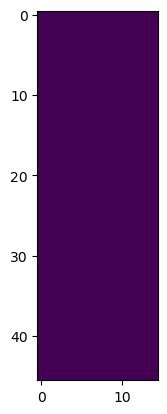

In [17]:
plt.imshow(ds.variables.u[3, :, :, 2])

Numerical diff

In [18]:
# Numerical directional derivative check for the full tensor

epsilon = 1e-4
direction = jax.random.normal(jax.random.PRNGKey(0), acc.state.variables.u.shape)
direction = direction / jnp.linalg.norm(direction)  # normalize


state_plus = acc.state.copy()
with state_plus.variables.unlock() :
    state_plus.variables.u = state_plus.variables.u + epsilon * direction
    f_plus = diff_function(state_plus)

state_minus = acc.state.copy()
with state_minus.variables.unlock() :
    state_minus.variables.u = state_minus.variables.u - epsilon * direction
    f_minus = diff_function(state_minus)

numerical_dir_deriv = (f_plus - f_minus) / (2 * epsilon)
analytical_dir_deriv = jnp.sum(ds.variables.u * direction)

print("Numerical directional derivative:", numerical_dir_deriv)
print("Analytical directional derivative:", analytical_dir_deriv)

Numerical directional derivative: 8.489304247229603e-08
Analytical directional derivative: 8.466390005845486e-08


# Using the tools 

In [60]:
from scripts.grad_compare import *

In [99]:
# Params auto-diff
def agg_sum(state, key_sum = 'u') :
    return ((getattr(state.variables, key_sum)[:,:,:] - 0)**2).mean()

step_function = acc.step
agg_function = agg_sum
var_name = 'u'
var = acc.state.variables.u.copy()
iteration_grad = 3


Backward

In [100]:
vjpm = vjp_grad(step_function, agg_function, var_name)

In [101]:
output_forward, gradients = vjpm.g(acc.state, var_value = var, iterations=iteration_grad)

Numerical diff

In [109]:
class numerical_dif_tensor(autodiff) :

    def g(self, state, var_value, direction, iterations=1, eps=1e-4, **kwargs) :

        wrap = partial(autodiff.wrapper,
                        step_fun=self.step_function,
                        var_name=self.var_name,
                        agg_func=self.agg_function,
                        iter=iterations)
        center = wrap(var_value, state)

        rgt = wrap(var_value - direction*eps, state)
        numerical_grad =  (center - rgt)/(eps)

        return center, numerical_grad

    def __str__(self) :
        return "numerical_diff tensor"

In [110]:
direction = jax.random.normal(jax.random.PRNGKey(0), acc.state.variables.u.shape)
direction = direction / jnp.linalg.norm(direction)  # normalize

In [111]:
ndm = numerical_dif_tensor(step_function, agg_function, var_name)
output_forward_nd, gradients_nd = ndm.g(acc.state, var_value = var, direction=direction, iterations=iteration_grad)

Compare

In [112]:
(gradients * direction).sum()

Array(-5.34651509e-07, dtype=float64)

In [113]:
gradients_nd

Array(-5.59481696e-07, dtype=float64)